<a href="https://colab.research.google.com/github/alexliqu09/fifa2022_2023/blob/main/EDA_fifa2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Descargando el conjunto de datos.

In [ ]:
!gdown 1z_A-yba-9q5N3f5fNJwm_HY3iRaY3yYS
!gdown 1aHh3-u4QqoczYIGOIa6bVEt9piaKg6Ai
!unzip /content/2022-2023FootballPlayerStats.zip
!mkdir FootballPlayerStats
!mv /content/"2022-2023 Football Player Stats.csv" FootballPlayerStats/FootballPlayerStats.csv
!mv /content/description.json FootballPlayerStats/

Downloading...
From: https://drive.google.com/uc?id=1z_A-yba-9q5N3f5fNJwm_HY3iRaY3yYS
To: /content/2022-2023FootballPlayerStats.zip
100% 481k/481k [00:00<00:00, 152MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aHh3-u4QqoczYIGOIa6bVEt9piaKg6Ai
To: /content/description.json
100% 6.99k/6.99k [00:00<00:00, 27.3MB/s]
Archive:  /content/2022-2023FootballPlayerStats.zip
  inflating: 2022-2023 Football Player Stats.csv  


## Librerias

In [ ]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Descripción de las variables

- Este json fue creado a raiz del conjunto de datos de kaggle Fifa 2023. Para nuestro facilitar el estudio se creo dicho archivo para tener una descripcion sobre nuestras variables. el conjunto de datos puede ser encontrado haciendo click [here](https://www.kaggle.com/datasets/vivovinco/20222023-football-player-stats?select=2022-2023+Football+Player+Stats.csv)

In [ ]:
with open('/content/FootballPlayerStats/description.json', 'r') as file:
    data = json.load(file)

description = pd.DataFrame(data.values(), index=data.keys(), columns=["description"])
description

,description
Rk,Ranking
Player,Nombre_del_Jugador
Nation,Nacionalidad_del_Jugador
Pos,Posición
Squad,Nombre_del_Equipo
...,...
OG,Goles_Propios_(en_contra)
Recov,Recuperaciones_de_balones_sueltos
AerWon,Duelos_Aéreos_Ganados
AerLost,Duelos_Aéreos_Perdidos


## Análisis exploratorio de datos.


In [ ]:
#una vez decargado el conjunto de dato se procedió ha realizar la lectura de datos y tomando como indice
path_name = "/content/FootballPlayerStats/FootballPlayerStats.csv"

players = pd.read_csv(path_name, encoding='latin-1', sep=";")
players.pop('Rk')
players.rename(columns={'Comp':'league'}, inplace=True)
print("Dataset cargado exitosamente")
print(f"N° de jugadores en el dataset: {players.shape[0]}")
print(f"N° de características: {players.shape[1]}")
#players = players.po('Rk')

Dataset cargado exitosamente
N° de jugadores en el dataset: 2689
N° de características: 123


### Revision de nulos


In [ ]:
players.isna().sum()

Player     0
Nation     1
Pos        0
Squad      0
league     0
          ..
OG         0
Recov      0
AerWon     0
AerLost    0
AerWon%    0
Length: 123, dtype: int64

In [ ]:
players['Nation'].fillna('Unknown', inplace=True)

### Separación de posición de roles


In [ ]:
players['Position'] = ''
players['Rol'] = ''

forward_position = ["FW", "FWMF", "FWDF"]
midfield_position = ["MF", "MFDF", "MFFW"]
defender_position = ["DF", "DFMF", "DFFW"]
goal_keeper= ["GK"]

for index, row in players.iterrows():
    pos = row['Pos']
    if pos in forward_position:
        players.at[index, 'Position'] = 'FW'
        players.at[index, 'Rol'] = pos.replace('FW', '')
    elif pos in midfield_position:
        players.at[index, 'Position'] = 'MF'
        players.at[index, 'Rol'] = pos.replace('MF', '')
    elif pos in defender_position:
        players.at[index, 'Position'] = 'DF'
        players.at[index, 'Rol'] = pos.replace('DF', '')
    elif pos in goal_keeper:
        players.at[index, 'Position'] = 'GK'
        players.at[index, 'Rol'] = pos.replace('GK', '-')

players['Rol'] = players['Rol'].replace('', 'C')
players.drop(columns=['Pos'], inplace=True)

### Quitando jugadores con una cantidad baja de minutos

-  Se optó por quitar a los jugadores que no han disputado muchos partidos en el conjuntod de datos para ello se tomo en cuenta la cantidad de encuentros y se decidió por un min de 5 partidos y a su vez que hallan jugado como min 45 min.

In [ ]:
print(f"El máximo de minutos jugados es: {players['Min'].max()}")
print(f"El mínimo de minutos jugados es: {players['Min'].min()}")
print(f"El máximo de partidos jugados es: {players['MP'].max()}")
print(f"El mínimo de partidos jugados es: {players['MP'].min()}")

El máximo de minutos jugados es: 2070
El mínimo de minutos jugados es: 1
El máximo de partidos jugados es: 23
El mínimo de partidos jugados es: 1


In [ ]:
players = players[(players['Min']>=225) & (players['MP']>=5)]

### Separando el conjunto de datos por Posicion

In [ ]:
forward = players[players['Position']=='FW']
midfielder = players[players['Position']=='MF']
defender = players[players['Position']=='DF']

### Seleccionado las variables a usar por posicion

- De las 123 variables que teniamos se estará separando en 3 grupos para anlizar a los jugadores, en este caso se esta tomando las algunas de las features más conocidas para analizar cada posición seguidamente mediante la matriz de correlación para analizar que variables podrian tener una correlación lineal y decidir cual seria prioritaria para el análisis.

In [ ]:
general_features = ['Player', 'Nation', 'Squad', 'league', 'Age', 'Born', 'Min', 'Position', 'Rol']

forward_features = ["Goals", "Shots", "SoT", "G/Sh", "G/SoT", "ShoDist", "GCA", "SCA", "Off", "PKwon", "ScaDrib", "Assists",
                    "ScaPassLive", "Car3rd", "ScaFld", "ToAtt", "ToSuc", "Carries", "CarTotDist", "CarPrgDist", 'CPA', "CarMis", "CarDis"]

midfielder_features = ["Goals","PasTotCmp", "PasTotCmp%", "PasTotDist", "PasTotPrgDist", "Assists", "PasAss", "Pas3rd", "Crs", "PasCmp",
                       "PasOff", "PasBlocks", "SCA", "ScaPassLive", "ScaPassDead", "ScaDrib", "ScaSh", "ScaFld", "GCA", "GcaPassLive",
                       "GcaPassDead", "GcaDrib", "GcaSh", "GcaFld", "Tkl", "TklWon", "TklDef3rd", "TklMid3rd", "TklAtt3rd", "TklDri",
                       "TklDriAtt", "TklDri%", "TklDriPast", "Blocks", "BlkSh", "Int", "Recov", "Carries", "CarTotDist", "CarPrgDist" , "Fld"]

defender_features = ["PasTotCmp", "PasTotDist", "PasTotPrgDist", "Tkl", "TklWon", "TklDef3rd", "TklMid3rd", "TklAtt3rd", "TklDri", "TklDriAtt", "TklDriPast", "Blocks",
                     "BlkSh", "Int", "Tkl+Int", "Recov", "AerWon", "AerLost", "Carries", "CarTotDist", "CarPrgDist", "CrdY", "CrdR","Fls", "Clr"]

In [ ]:
def get_high_correlations(dataframe, correlation_threshold, upper_only=True):
    corr_matrix = dataframe.corr()

    high_correlations = []
    for column in corr_matrix.columns:
        for index, value in enumerate(corr_matrix[column]):
            if index != corr_matrix.columns.get_loc(column):
                if (upper_only and index < corr_matrix.columns.get_loc(column)) or not upper_only:
                    if abs(value) > correlation_threshold:
                        high_correlations.append((column, corr_matrix.columns[index], value))

    return high_correlations

### Correlación delanteros

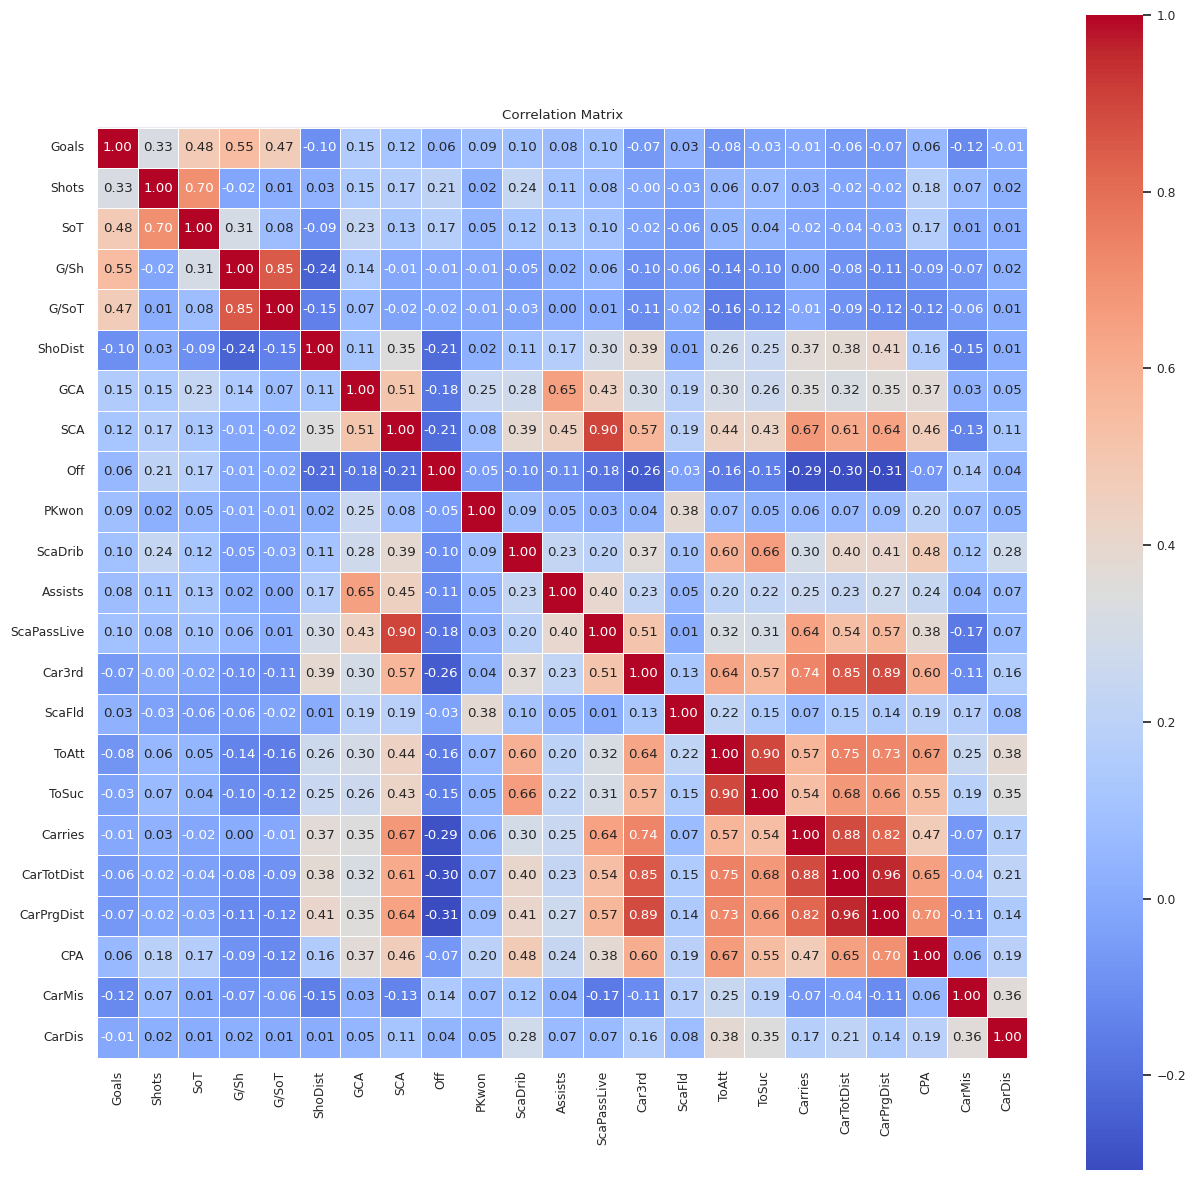

In [ ]:
plt.figure(figsize=(15, 15))
sns.set(font_scale=0.8)
sns.heatmap(forward[forward_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
get_high_correlations(forward[forward_features], 0.5)

[('SoT', 'Shots', 0.7039982830968404),
 ('G/Sh', 'Goals', 0.5464584931985554),
 ('G/SoT', 'G/Sh', 0.8477191382887532),
 ('SCA', 'GCA', 0.5083001361049102),
 ('Assists', 'GCA', 0.6523264595734967),
 ('ScaPassLive', 'SCA', 0.9000873109145231),
 ('Car3rd', 'SCA', 0.5749624451684457),
 ('Car3rd', 'ScaPassLive', 0.5110847263950161),
 ('ToAtt', 'ScaDrib', 0.595623361404675),
 ('ToAtt', 'Car3rd', 0.6366182642522296),
 ('ToSuc', 'ScaDrib', 0.6613888417806019),
 ('ToSuc', 'Car3rd', 0.5688000051269338),
 ('ToSuc', 'ToAtt', 0.895945352347528),
 ('Carries', 'SCA', 0.6749235187169924),
 ('Carries', 'ScaPassLive', 0.643348593387632),
 ('Carries', 'Car3rd', 0.7354719094225202),
 ('Carries', 'ToAtt', 0.5744251200122077),
 ('Carries', 'ToSuc', 0.5360856903230444),
 ('CarTotDist', 'SCA', 0.6144310951187973),
 ('CarTotDist', 'ScaPassLive', 0.537104872682596),
 ('CarTotDist', 'Car3rd', 0.8542153589514486),
 ('CarTotDist', 'ToAtt', 0.7490819378958796),
 ('CarTotDist', 'ToSuc', 0.6762636599920011),
 ('CarTo

In [ ]:
forward_features_indepent = [
  "Goals", "SoT%", "ShoDist", "SCA", "Off", "PKwon", "ScaDrib", "Assists",
  "ScaFld", "CarMis", "CarDis"
]

In [ ]:
get_high_correlations(forward[forward_features_indepent], 0.5)

[]

### Correlacion Mediocampo

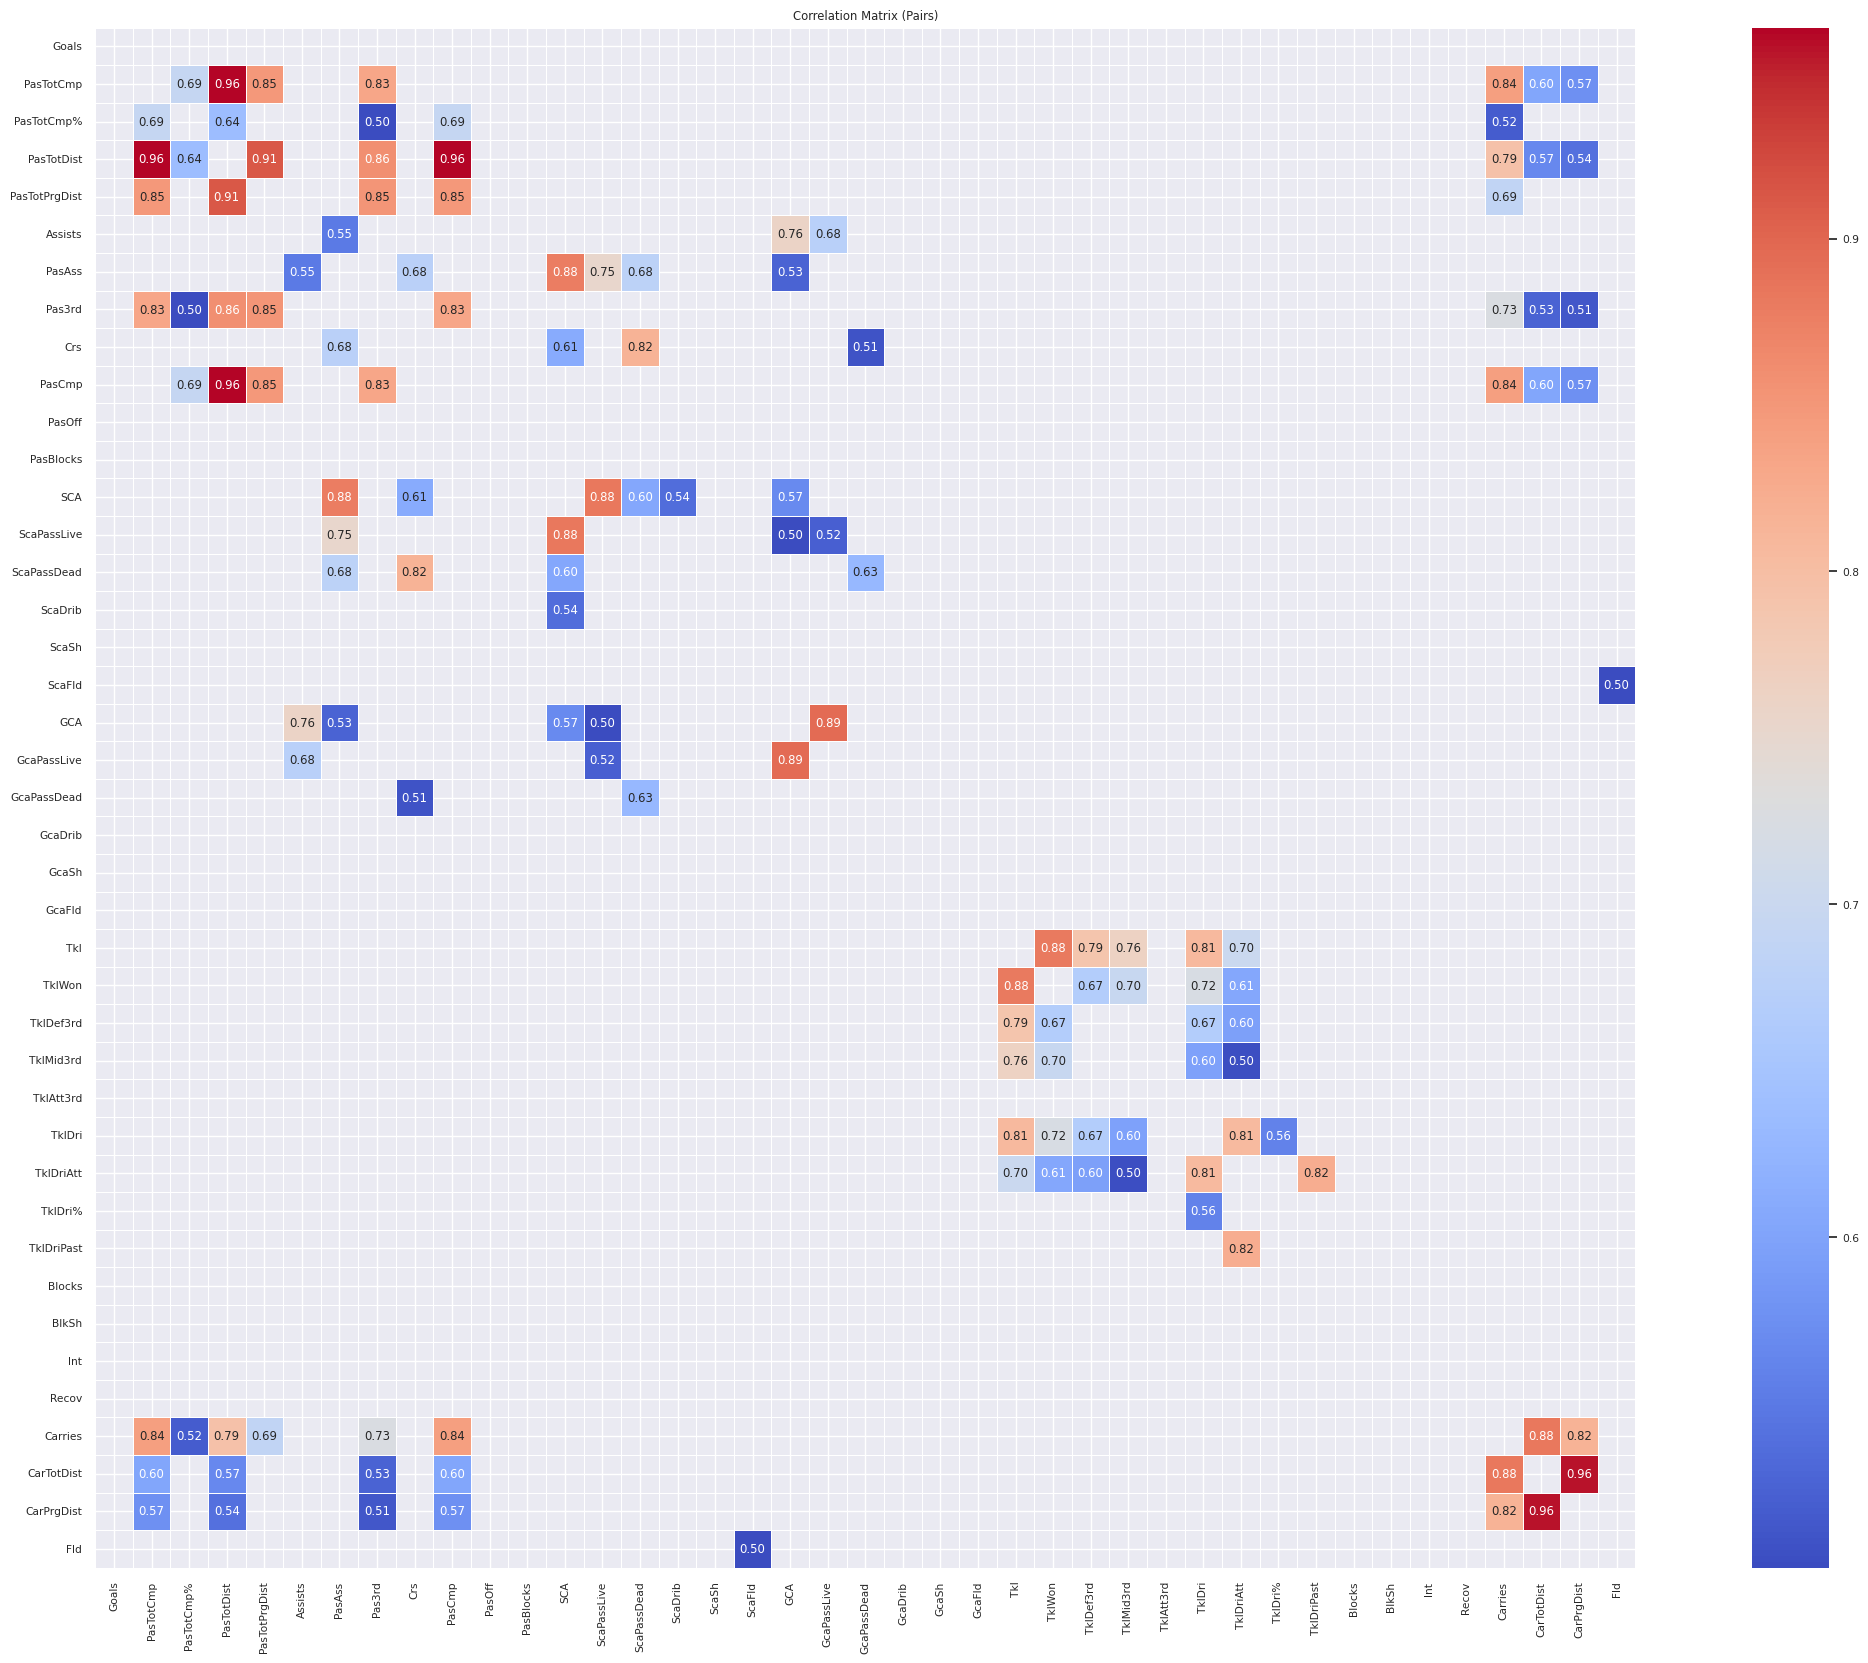

In [ ]:
corr_matrix = midfielder[midfielder_features].corr()

umbral_correlacion = 0.5
correlaciones_pares = (corr_matrix.abs() > umbral_correlacion) & (corr_matrix.abs() < 1.0)

plt.figure(figsize=(30, 20))
sns.set(font_scale=0.7)
sns.heatmap(corr_matrix[correlaciones_pares], annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title('Correlation Matrix (Pairs)')
plt.show()

In [ ]:
get_high_correlations(midfielder[midfielder_features], 0.5)

[('PasTotCmp%', 'PasTotCmp', 0.6936852310897786),
 ('PasTotDist', 'PasTotCmp', 0.9633461655798795),
 ('PasTotDist', 'PasTotCmp%', 0.637229275389551),
 ('PasTotPrgDist', 'PasTotCmp', 0.8493699920860753),
 ('PasTotPrgDist', 'PasTotDist', 0.9121582191165213),
 ('PasAss', 'Assists', 0.5508015733959346),
 ('Pas3rd', 'PasTotCmp', 0.832426871974942),
 ('Pas3rd', 'PasTotCmp%', 0.5006255799853042),
 ('Pas3rd', 'PasTotDist', 0.8589815483777169),
 ('Pas3rd', 'PasTotPrgDist', 0.851823523094034),
 ('Crs', 'PasAss', 0.6769365157256991),
 ('PasCmp', 'PasTotCmp', 1.0),
 ('PasCmp', 'PasTotCmp%', 0.6936852310897789),
 ('PasCmp', 'PasTotDist', 0.9633461655798795),
 ('PasCmp', 'PasTotPrgDist', 0.8493699920860753),
 ('PasCmp', 'Pas3rd', 0.832426871974942),
 ('SCA', 'PasAss', 0.8778342596059908),
 ('SCA', 'Crs', 0.610790466387693),
 ('ScaPassLive', 'PasAss', 0.7531500867700379),
 ('ScaPassLive', 'SCA', 0.8830030547797749),
 ('ScaPassDead', 'PasAss', 0.6797760113026279),
 ('ScaPassDead', 'Crs', 0.81541518254

In [ ]:
midfielder_features_independent = [
    "Goals", "Pas3rd", "Crs", "PasOff", "PasBlocks", "ScaDrib", "ScaSh", "ScaFld", "GcaPassLive",
    "GcaDrib", "GcaSh", "GcaFld", "TklDef3rd", "TklMid3rd", "TklAtt3rd", "TklDriPast", "Blocks",
    "BlkSh", "Int", "Recov"]


### Correlación defensas

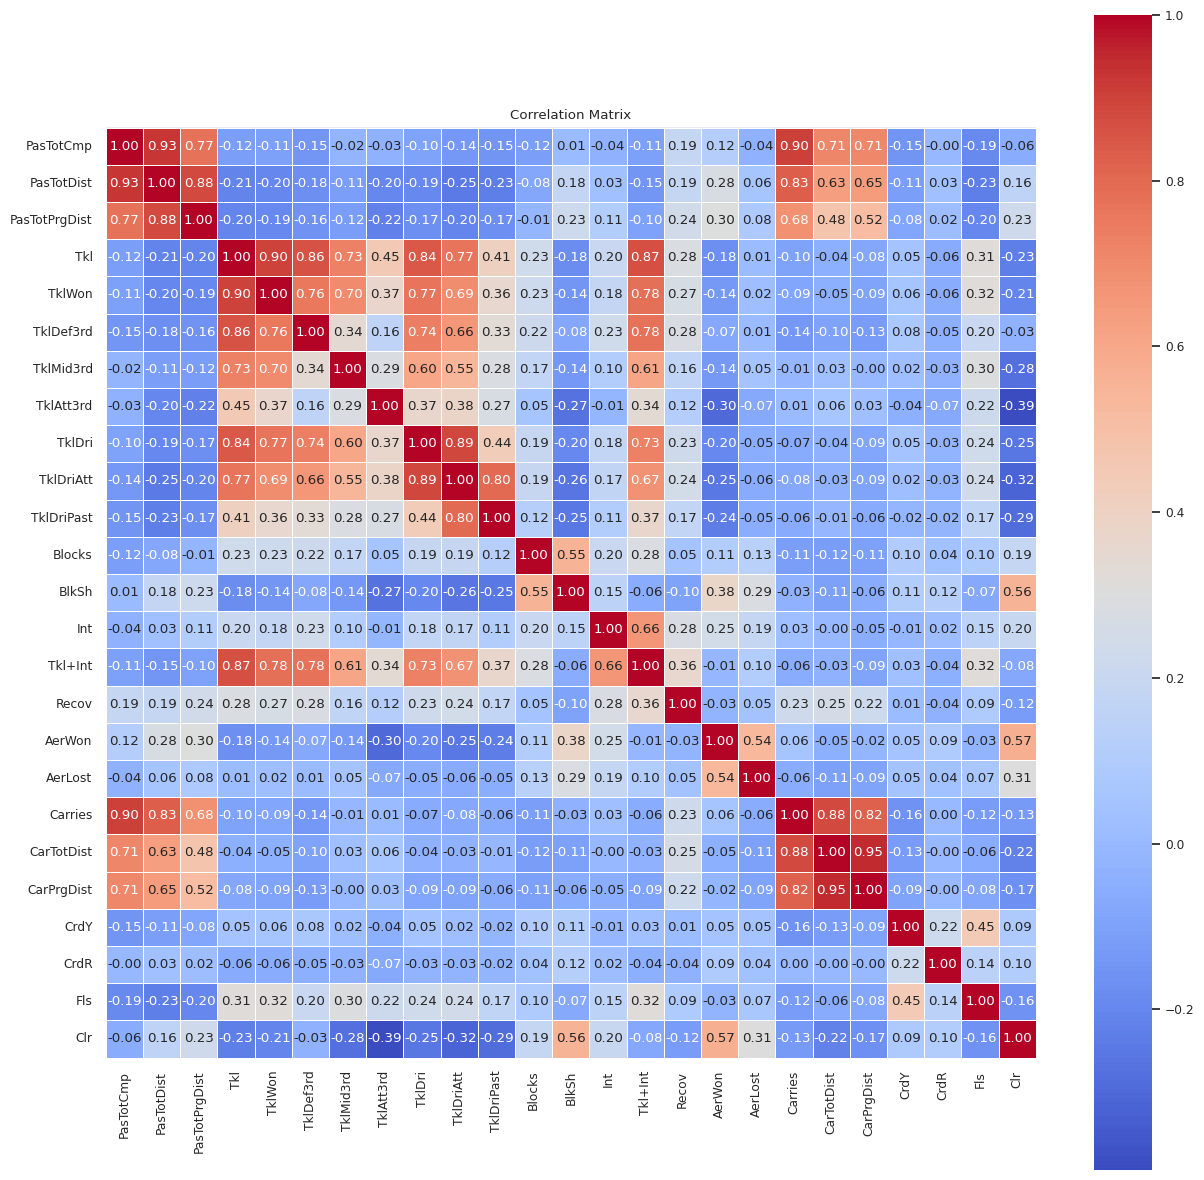

In [ ]:
plt.figure(figsize=(15, 15))
sns.set(font_scale=0.8)
sns.heatmap(defender[defender_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
get_high_correlations(defender[defender_features], 0.5)

[('PasTotDist', 'PasTotCmp', 0.9252412951171863),
 ('PasTotPrgDist', 'PasTotCmp', 0.7716424214900811),
 ('PasTotPrgDist', 'PasTotDist', 0.8824999229346576),
 ('TklWon', 'Tkl', 0.8974775675716317),
 ('TklDef3rd', 'Tkl', 0.8608156858354692),
 ('TklDef3rd', 'TklWon', 0.7567874956838616),
 ('TklMid3rd', 'Tkl', 0.7300720836414234),
 ('TklMid3rd', 'TklWon', 0.698871537604756),
 ('TklDri', 'Tkl', 0.8421856805233908),
 ('TklDri', 'TklWon', 0.7665192103349385),
 ('TklDri', 'TklDef3rd', 0.7368185957061508),
 ('TklDri', 'TklMid3rd', 0.6044506699294735),
 ('TklDriAtt', 'Tkl', 0.7692280145873337),
 ('TklDriAtt', 'TklWon', 0.6929267879325253),
 ('TklDriAtt', 'TklDef3rd', 0.6607381076725379),
 ('TklDriAtt', 'TklMid3rd', 0.5469078749102235),
 ('TklDriAtt', 'TklDri', 0.8888034728961305),
 ('TklDriPast', 'TklDriAtt', 0.8013567026348278),
 ('BlkSh', 'Blocks', 0.5539662044829724),
 ('Tkl+Int', 'Tkl', 0.8651114003579236),
 ('Tkl+Int', 'TklWon', 0.7769081358605774),
 ('Tkl+Int', 'TklDef3rd', 0.7755453066830

In [ ]:
defender_features_independent = [
    "PasTotCmp%", "TklDef3rd", "TklDriPast", "BlkSh", "Int", "Recov",
    "AerWon", "AerLost", "CrdY", "CrdR","Fls"
]

### Revisando los min y máx así como la desviación std de nuestros datos

In [ ]:
forward_features_indepent = general_features + forward_features_indepent
midfielder_features_independent = general_features + midfielder_features_independent
defender_features_independent = general_features + defender_features_independent

In [ ]:
forward = forward[forward_features_indepent]
midfielder = midfielder[midfielder_features_independent]
defender = defender[defender_features_independent]

In [ ]:
forward[forward_features_indepent].describe()

,Age,Born,Min,Goals,SoT%,ShoDist,SCA,Off,PKwon,ScaDrib,Assists,ScaFld,CarMis,CarDis
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.00000,452.000000,452.000000
mean,26.457965,1995.683628,904.334071,3.404867,37.681195,15.892257,2.791018,0.544425,0.027456,0.202987,0.139027,0.19885,2.757058,1.578628
std,4.305465,4.316667,447.283970,3.297150,13.615134,3.128987,1.056982,0.416830,0.061615,0.201804,0.148684,0.18978,0.949687,0.671413
min,17.000000,1983.000000,225.000000,0.000000,0.000000,0.000000,0.230000,0.000000,0.000000,0.000000,0.000000,0.00000,0.710000,0.000000
25%,23.000000,1993.000000,515.500000,1.000000,28.825000,13.700000,2.047500,0.250000,0.000000,0.000000,0.000000,0.03750,2.107500,1.110000
50%,26.000000,1996.000000,878.500000,3.000000,38.200000,15.700000,2.595000,0.475000,0.000000,0.150000,0.110000,0.17000,2.650000,1.495000
75%,29.000000,1999.000000,1217.500000,5.000000,46.050000,17.700000,3.435000,0.770000,0.000000,0.310000,0.220000,0.29000,3.330000,1.952500
max,40.000000,2005.000000,2055.000000,25.000000,100.000000,25.800000,6.150000,2.800000,0.430000,1.060000,0.820000,1.20000,6.430000,3.850000


In [ ]:
midfielder[midfielder_features_independent].describe()

,Age,Born,Min,Goals,Pas3rd,Crs,PasOff,PasBlocks,ScaDrib,ScaSh,...,GcaSh,GcaFld,TklDef3rd,TklMid3rd,TklAtt3rd,TklDriPast,Blocks,BlkSh,Int,Recov
count,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,...,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000
mean,26.224223,1995.960720,985.148936,1.263502,3.713224,1.813666,0.200016,0.952635,0.098936,0.142242,...,0.016547,0.015646,0.825286,0.944239,0.288658,0.919214,1.201833,0.220753,0.927889,5.990556
std,4.047724,4.060012,474.725138,1.717115,1.863203,1.813267,0.189138,0.472068,0.151141,0.160726,...,0.044124,0.043439,0.503776,0.474893,0.231063,0.495790,0.512367,0.214037,0.514068,1.491268
min,16.000000,1985.000000,226.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,1993.000000,566.500000,0.000000,2.400000,0.420000,0.060000,0.630000,0.000000,0.000000,...,0.000000,0.000000,0.460000,0.610000,0.140000,0.580000,0.830000,0.050000,0.540000,4.950000
50%,26.000000,1996.000000,961.000000,1.000000,3.390000,1.140000,0.180000,0.910000,0.000000,0.100000,...,0.000000,0.000000,0.770000,0.900000,0.250000,0.850000,1.140000,0.180000,0.910000,5.940000
75%,29.000000,1999.000000,1391.500000,2.000000,4.735000,2.640000,0.290000,1.210000,0.145000,0.220000,...,0.000000,0.000000,1.105000,1.225000,0.390000,1.180000,1.515000,0.340000,1.250000,6.965000
max,37.000000,2006.000000,1980.000000,12.000000,15.400000,10.100000,1.850000,3.000000,1.300000,1.070000,...,0.290000,0.310000,4.810000,2.750000,1.610000,3.750000,3.430000,1.210000,2.970000,10.600000


In [ ]:
defender[defender_features_independent].describe()

,Age,Born,Min,PasTotCmp%,TklDef3rd,TklDriPast,BlkSh,Int,Recov,AerWon,AerLost,CrdY,CrdR,Fls
count,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000
mean,26.674003,1995.492435,1072.496561,79.937689,1.083521,0.548941,0.506630,1.215543,5.498817,1.532545,1.187263,0.206988,0.014415,1.043755
std,4.104647,4.108331,473.089750,7.359863,0.538042,0.373441,0.355513,0.534087,1.221881,0.896771,0.583299,0.156629,0.044165,0.472686
min,17.000000,1983.000000,227.000000,52.300000,0.000000,0.000000,0.000000,0.000000,2.050000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,1992.000000,646.500000,75.200000,0.710000,0.270000,0.250000,0.840000,4.670000,0.825000,0.800000,0.100000,0.000000,0.710000
50%,26.000000,1996.000000,1090.000000,80.600000,1.010000,0.480000,0.450000,1.140000,5.370000,1.460000,1.120000,0.190000,0.000000,0.980000
75%,30.000000,1999.000000,1448.500000,85.550000,1.355000,0.740000,0.710000,1.520000,6.265000,2.090000,1.465000,0.290000,0.000000,1.330000
max,39.000000,2005.000000,2069.000000,95.500000,3.900000,2.460000,2.140000,3.860000,9.290000,5.940000,4.330000,1.020000,0.420000,2.980000


## Gráficos

#### Delanteros

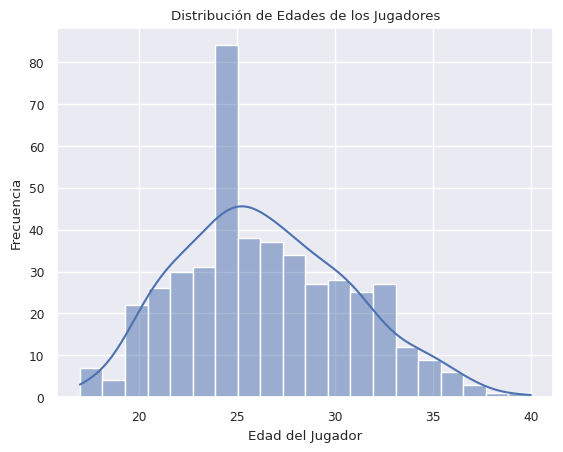

In [ ]:
sns.histplot(data=forward, x='Age', bins=20, kde=True)
plt.title('Distribución de Edades de los Jugadores')
plt.xlabel('Edad del Jugador')
plt.ylabel('Frecuencia')
plt.show()

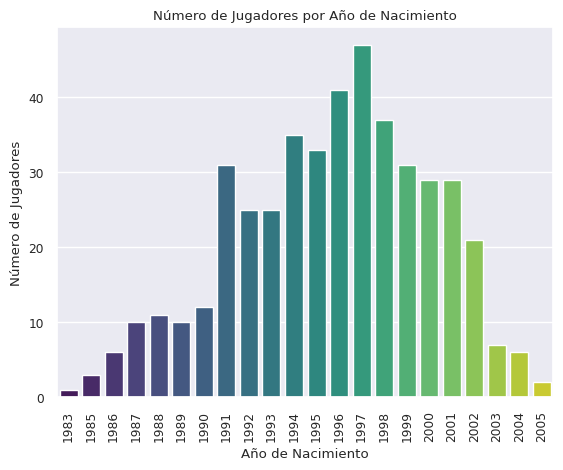

In [ ]:
sns.countplot(data=forward, x='Born', palette='viridis')
plt.title('Número de Jugadores por Año de Nacimiento')
plt.xlabel('Año de Nacimiento')
plt.ylabel('Número de Jugadores')
plt.xticks(rotation=90)
plt.show()

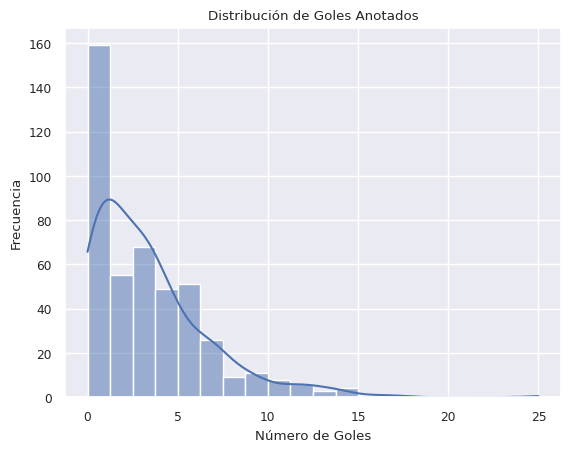

In [ ]:
sns.histplot(data=forward, x='Goals', bins=20, kde=True)
plt.title('Distribución de Goles Anotados')
plt.xlabel('Número de Goles')
plt.ylabel('Frecuencia')
plt.show()

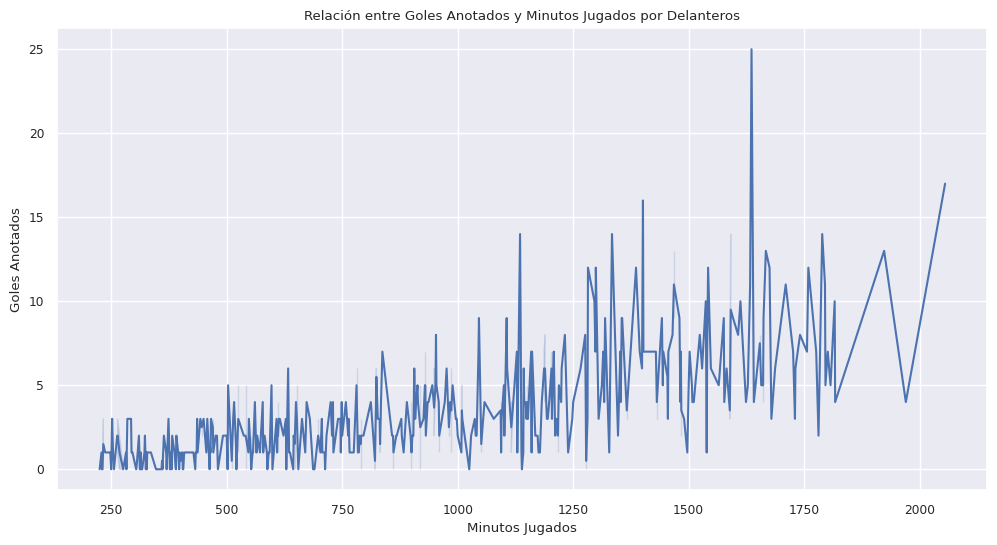

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=forward, x='Min', y='Goals')
plt.xlabel('Minutos Jugados')
plt.ylabel('Goles Anotados')
plt.title('Relación entre Goles Anotados y Minutos Jugados por Delanteros')
plt.show()

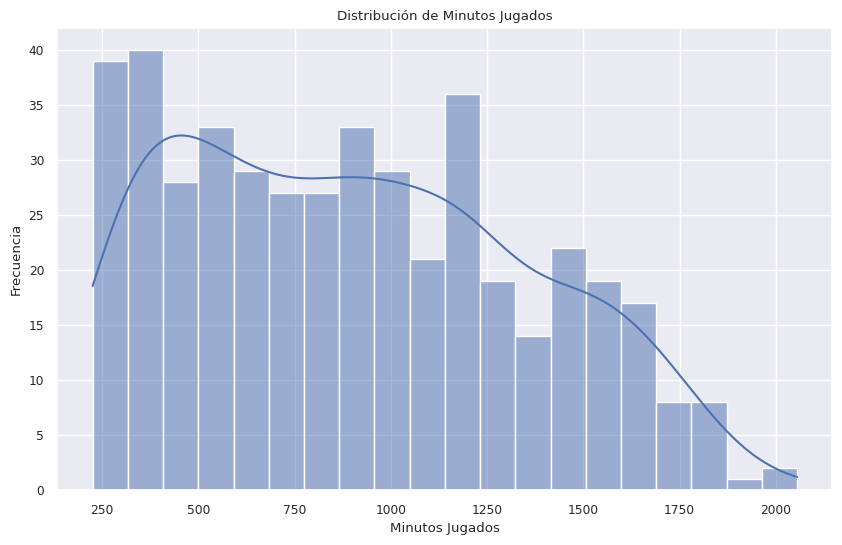

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=forward, x='Min', bins=20, kde=True)
plt.xlabel('Minutos Jugados')
plt.ylabel('Frecuencia')
plt.title('Distribución de Minutos Jugados')
plt.show()

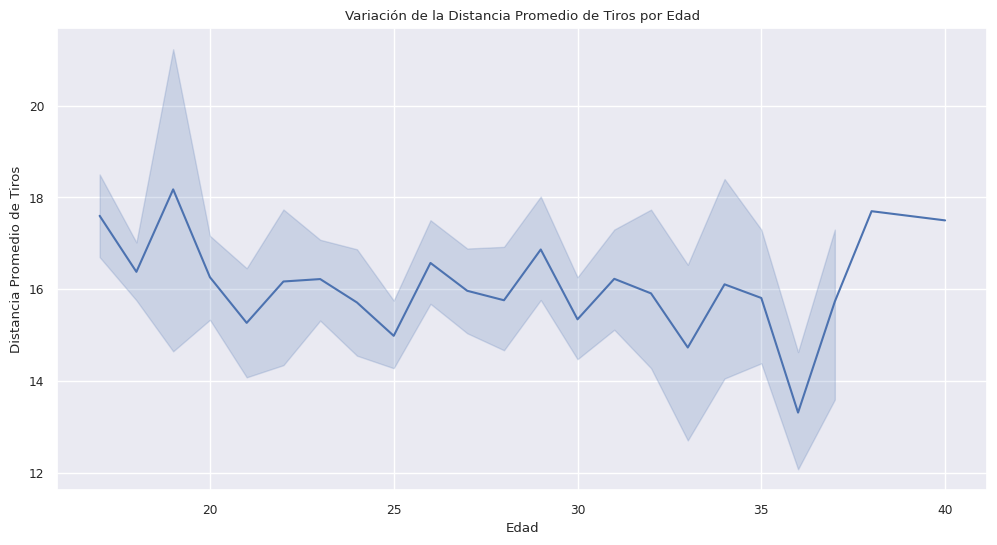

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=forward, x='Age', y='ShoDist')
plt.xlabel('Edad')
plt.ylabel('Distancia Promedio de Tiros')
plt.title('Variación de la Distancia Promedio de Tiros por Edad')
plt.show()

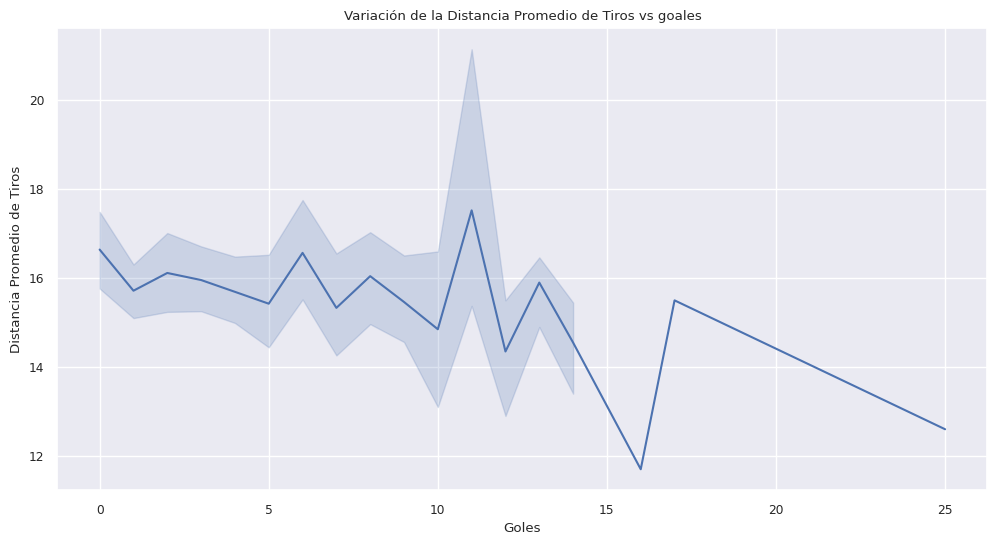

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=forward, x='Goals', y='ShoDist')
plt.xlabel('Goles')
plt.ylabel('Distancia Promedio de Tiros')
plt.title('Variación de la Distancia Promedio de Tiros vs goales')
plt.show()

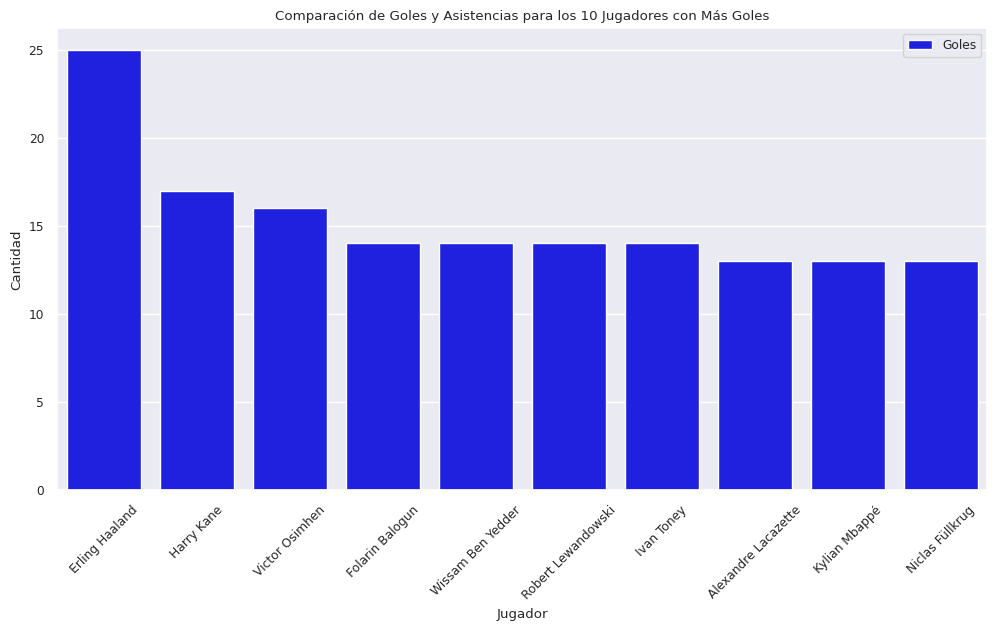

In [ ]:
top_10_goles = forward.sort_values(by='Goals', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_goles, x='Player', y='Goals', color='blue', label='Goles')
plt.xlabel('Jugador')
plt.ylabel('Cantidad')
plt.title('Comparación de Goles y Asistencias para los 10 Jugadores con Más Goles')
plt.xticks(rotation=45)
plt.legend()
plt.show()

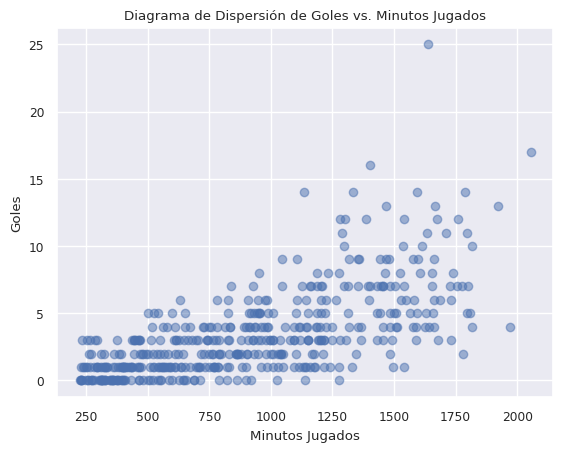

In [ ]:
"""
Diagrama de Dispersión de Goles vs. Minutos:
Este gráfico te mostrará cómo se distribuyen los goles en función de los minutos jugados por cada jugador

"""

plt.scatter(forward['Min'], forward['Goals'], alpha=0.5)
plt.xlabel('Minutos Jugados')
plt.ylabel('Goles')
plt.title('Diagrama de Dispersión de Goles vs. Minutos Jugados')
plt.show()

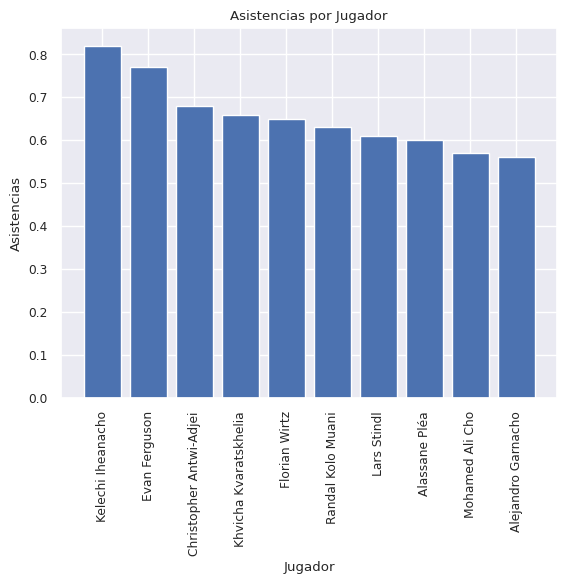

In [ ]:
top_10_pases = forward.sort_values(by='Assists', ascending=False).head(10)

plt.bar(top_10_pases['Player'], top_10_pases['Assists'])
plt.xlabel('Jugador')
plt.ylabel('Asistencias')
plt.title('Asistencias por Jugador')
plt.xticks(rotation=90)  # Rotar etiquetas en el eje x para una mejor legibilidad
plt.show()

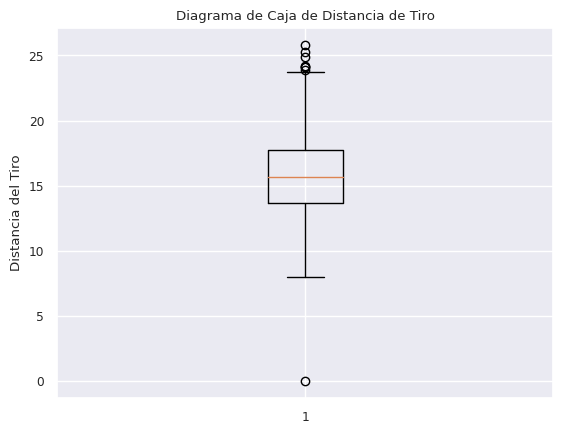

In [ ]:
plt.boxplot(forward['ShoDist'])
plt.ylabel('Distancia del Tiro')
plt.title('Diagrama de Caja de Distancia de Tiro')
plt.show()

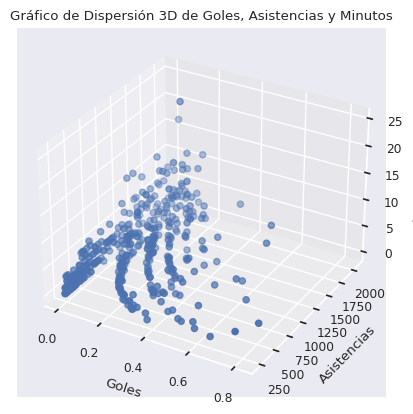

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(forward['Assists'], forward['Min'], forward['Goals'])
ax.set_xlabel('Goles')
ax.set_ylabel('Asistencias')
ax.set_zlabel('Minutos Jugados')
ax.set_title('Gráfico de Dispersión 3D de Goles, Asistencias y Minutos')

plt.show()

# Consultas

In [ ]:
print(forward.columns)
print(midfielder.columns)
print(defender.columns)

Index(['Player', 'Nation', 'Squad', 'league', 'Age', 'Born', 'Min', 'Position',
       'Rol', 'Goals', 'SoT%', 'ShoDist', 'SCA', 'Off', 'PKwon', 'ScaDrib',
       'Assists', 'ScaFld', 'CarMis', 'CarDis'],
      dtype='object')
Index(['Player', 'Nation', 'Squad', 'league', 'Age', 'Born', 'Min', 'Position',
       'Rol', 'Goals', 'Pas3rd', 'Crs', 'PasOff', 'PasBlocks', 'ScaDrib',
       'ScaSh', 'ScaFld', 'GcaPassLive', 'GcaDrib', 'GcaSh', 'GcaFld',
       'TklDef3rd', 'TklMid3rd', 'TklAtt3rd', 'TklDriPast', 'Blocks', 'BlkSh',
       'Int', 'Recov'],
      dtype='object')
Index(['Player', 'Nation', 'Squad', 'league', 'Age', 'Born', 'Min', 'Position',
       'Rol', 'PasTotCmp%', 'TklDef3rd', 'TklDriPast', 'BlkSh', 'Int', 'Recov',
       'AerWon', 'AerLost', 'CrdY', 'CrdR', 'Fls'],
      dtype='object')


In [ ]:
# 1. Consulta para obtener los 10 jugadores con más goles:
top_10_goleadores = forward.nlargest(10, 'Goals')
top_10_goleadores[['Player', 'Nation', 'Squad', 'league', 'Age', 'Goals']]

,Player,Nation,Squad,league,Age,Goals
1057,Erling Haaland,NOR,Manchester City,Premier League,22,25
1260,Harry Kane,ENG,Tottenham,Premier League,29,17
1858,Victor Osimhen,NGA,Napoli,Serie A,24,16
184,Folarin Balogun,ENG,Reims,Ligue 1,21,14
252,Wissam Ben Yedder,FRA,Monaco,Ligue 1,32,14
1426,Robert Lewandowski,POL,Barcelona,La Liga,34,14
2451,Ivan Toney,ENG,Brentford,Premier League,26,14
899,Niclas Füllkrug,GER,Werder Bremen,Bundesliga,30,13
1358,Alexandre Lacazette,FRA,Lyon,Ligue 1,31,13
1609,Kylian Mbappé,FRA,Paris S-G,Ligue 1,24,13


In [ ]:
# 2. Consulta para encontrar la edad promedio de los jugadores:
edad_promedio = forward['Age'].mean()
edad_promedio

26.457964601769913

In [ ]:
# 3. Consulta para calcular el promedio de tiros a portería (SoT%) y la distancia promedio de los tiros (ShoDist):
promedio_sot_shodist = forward[['SoT%', 'ShoDist']].mean()
promedio_sot_shodist

SoT%       37.681195
ShoDist    15.892257
dtype: float64

In [ ]:
# 2. Consulta para calcular el promedio de recuperaciones (Recov) por liga (league):
promedio_recuperaciones_por_liga = midfielder.groupby('league')['Recov'].mean()
promedio_recuperaciones_por_liga

league
Bundesliga        5.978636
La Liga           5.568244
Ligue 1           6.245769
Premier League    6.284909
Serie A           5.921923
Name: Recov, dtype: float64